In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model_h as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [5]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [6]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 0, 10: 8, 11: 6, 12: 0, 13: 7, 14: 5, 15: 8, 16: 0, 17: 9, 18: 10, 19: 11, 20: 0, 21: 12, 22: 0, 23: 13, 24: 14, 25: 15, 26: 16, 27: 17, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [7]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMIGOGN1_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMIGOGN1_Bedroom_id0
3FO4MMIGOGN1_Bedroom_id1
3FO4MMIGOGN1_Bedroom_id2
3FO4MMIGOGN1_Bedroom_id3
3FO4MMIGOGN1_Bedroom_id4
3FO4MMIGOGN1_Bedroom_id5
3FO4MMIGOGN1_Bedroom_id6
3FO4MMIGOGN1_Bedroom_id7
3FO4MMIGOGN1_Bedroom_id8
3FO4MMIGOGN1_Bedroom_id9
3FO4MMIGOGN1_Bedroom_id10
3FO4MMIGOGN1_Bedroom_id11
3FO4MMIGOGN1_Bedroom_id12
3FO4MMIGOGN1_Bedroom_id13
3FO4MMIGOGN1_Bedroom_id14
3FO4MMIGOGN1_Bedroom_id15
3FO4MMIGOGN1_Bedroom_id16
3FO4MMIGOGN1_Bedroom_id17
3FO4MMIGOGN1_Bedroom_id18
3FO4MMIGOGN1_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6CI92_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6CI92_Living_room_id0
3FO4MKV6CI92_Living_room_id1
3FO4MKV6CI92_Living_room

3FO4MMH005SW_Bedroom_id0
3FO4MMH005SW_Bedroom_id1
3FO4MMH005SW_Bedroom_id2
3FO4MMH005SW_Bedroom_id3
3FO4MMH005SW_Bedroom_id4
3FO4MMH005SW_Bedroom_id5
3FO4MMH005SW_Bedroom_id6
3FO4MMH005SW_Bedroom_id7
3FO4MMH005SW_Bedroom_id8
3FO4MMH005SW_Bedroom_id9
3FO4MMH005SW_Bedroom_id10
3FO4MMH005SW_Bedroom_id11
3FO4MMH005SW_Bedroom_id12
3FO4MMH005SW_Bedroom_id13
3FO4MMH005SW_Bedroom_id14
3FO4MMH005SW_Bedroom_id15
3FO4MMH005SW_Bedroom_id16
3FO4MMH005SW_Bedroom_id17
3FO4MMH005SW_Bedroom_id18
3FO4MMH005SW_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFI67Q2A_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFI67Q2A_Living_room_id0
3FO4MFI67Q2A_Living_room_id1
3FO4MFI67Q2A_Living_room_id2
3FO4MFI67Q2A_Living_room_id3
3FO4MFI67Q2A_Living_room_id4
3FO4MFI67Q2A_Living_room_id5
3FO4MFI67Q2A_Living_room_id6
3FO4MFI67Q2A_Living_room_id8
3FO4MFI67Q2A_Living_room_id9
3FO4MFI67Q2A_Living_room_id10
3FO4MFI67Q2A_Living_room_

Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6XX73BN_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6XX73BN_Guest_room_id2
3FO4M6XX73BN_Guest_room_id3
3FO4M6XX73BN_Guest_room_id6
3FO4M6XX73BN_Guest_room_id9
3FO4M6XX73BN_Guest_room_id12
3FO4M6XX73BN_Guest_room_id13
3FO4M6XX73BN_Guest_room_id14
3FO4M6XX73BN_Guest_room_id17
3FO4M6XX73BN_Guest_room_id18
3FO4M6XX73BN_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLS2PJ0P_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLS2PJ0P_Living_room_id0
3FO4MLS2PJ0P_Living_room_id1
3FO4MLS2PJ0P_Living_room_id2
3FO4MLS2PJ0P_Living_room_id3
3FO4MLS2PJ0P_Living_room_id4
3FO4MLS2PJ0P_Living_room_id5
3FO4MLS2PJ0P_Living_room_id6
3FO4MLS2PJ0P_Living_room_id7
3FO4MLS2PJ0P_Living_room_id8
3FO4MLS2PJ0P_Living_room_id9
3FO4MLS2PJ0P_Living_room_id10

Done (t=0.00s)
creating index...
index created!
3FO4M4R6P4KS_Guest_room_id0
3FO4M4R6P4KS_Guest_room_id1
3FO4M4R6P4KS_Guest_room_id2
3FO4M4R6P4KS_Guest_room_id3
3FO4M4R6P4KS_Guest_room_id6
3FO4M4R6P4KS_Guest_room_id8
3FO4M4R6P4KS_Guest_room_id10
3FO4M4R6P4KS_Guest_room_id11
3FO4M4R6P4KS_Guest_room_id13
3FO4M4R6P4KS_Guest_room_id14
3FO4M4R6P4KS_Guest_room_id15
3FO4M4R6P4KS_Guest_room_id16
3FO4M4R6P4KS_Guest_room_id17
3FO4M4R6P4KS_Guest_room_id18
3FO4M4R6P4KS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4METFL4GR_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4METFL4GR_Living_room_id0
3FO4METFL4GR_Living_room_id1
3FO4METFL4GR_Living_room_id2
3FO4METFL4GR_Living_room_id3
3FO4METFL4GR_Living_room_id4
3FO4METFL4GR_Living_room_id5
3FO4METFL4GR_Living_room_id6
3FO4METFL4GR_Living_room_id7
3FO4METFL4GR_Living_room_id8
3FO4METFL4GR_Living_room_id9
3FO4METFL4GR_Living_room_id10
3FO4METFL4GR_Living_room_id11

Done (t=0.00s)
creating index...
index created!
3FO4MDKK3TAX_Dining_room_id0
3FO4MDKK3TAX_Dining_room_id1
3FO4MDKK3TAX_Dining_room_id2
3FO4MDKK3TAX_Dining_room_id3
3FO4MDKK3TAX_Dining_room_id4
3FO4MDKK3TAX_Dining_room_id5
3FO4MDKK3TAX_Dining_room_id6
3FO4MDKK3TAX_Dining_room_id7
3FO4MDKK3TAX_Dining_room_id8
3FO4MDKK3TAX_Dining_room_id9
3FO4MDKK3TAX_Dining_room_id10
3FO4MDKK3TAX_Dining_room_id11
3FO4MDKK3TAX_Dining_room_id12
3FO4MDKK3TAX_Dining_room_id13
3FO4MDKK3TAX_Dining_room_id14
3FO4MDKK3TAX_Dining_room_id15
3FO4MDKK3TAX_Dining_room_id16
3FO4MDKK3TAX_Dining_room_id17
3FO4MDKK3TAX_Dining_room_id18
3FO4MDKK3TAX_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MELE68CX_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MELE68CX_Living_room_id0
3FO4MELE68CX_Living_room_id1
3FO4MELE68CX_Living_room_id2
3FO4MELE68CX_Living_room_id3
3FO4MELE68CX_Living_room_id4
3FO4MELE68CX_Living_room_id5
3FO4MELE68CX_L

3FO4MFPOFVKO_Living_room_id0
3FO4MFPOFVKO_Living_room_id1
3FO4MFPOFVKO_Living_room_id2
3FO4MFPOFVKO_Living_room_id3
3FO4MFPOFVKO_Living_room_id4
3FO4MFPOFVKO_Living_room_id5
3FO4MFPOFVKO_Living_room_id6
3FO4MFPOFVKO_Living_room_id7
3FO4MFPOFVKO_Living_room_id8
3FO4MFPOFVKO_Living_room_id9
3FO4MFPOFVKO_Living_room_id10
3FO4MFPOFVKO_Living_room_id11
3FO4MFPOFVKO_Living_room_id12
3FO4MFPOFVKO_Living_room_id13
3FO4MFPOFVKO_Living_room_id14
3FO4MFPOFVKO_Living_room_id15
3FO4MFPOFVKO_Living_room_id16
3FO4MFPOFVKO_Living_room_id17
3FO4MFPOFVKO_Living_room_id18
3FO4MFPOFVKO_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6RQ9VA_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6RQ9VA_Guest_room_id0
3FO4MF6RQ9VA_Guest_room_id1
3FO4MF6RQ9VA_Guest_room_id2
3FO4MF6RQ9VA_Guest_room_id3
3FO4MF6RQ9VA_Guest_room_id4
3FO4MF6RQ9VA_Guest_room_id5
3FO4MF6RQ9VA_Guest_room_id6
3FO4MF6RQ9VA_Guest_room_id7
3FO4MF6RQ9VA_

Done (t=0.00s)
creating index...
index created!
3FO4MFDMNAEL_Living_room_id0
3FO4MFDMNAEL_Living_room_id1
3FO4MFDMNAEL_Living_room_id2
3FO4MFDMNAEL_Living_room_id3
3FO4MFDMNAEL_Living_room_id4
3FO4MFDMNAEL_Living_room_id5
3FO4MFDMNAEL_Living_room_id6
3FO4MFDMNAEL_Living_room_id7
3FO4MFDMNAEL_Living_room_id8
3FO4MFDMNAEL_Living_room_id9
3FO4MFDMNAEL_Living_room_id10
3FO4MFDMNAEL_Living_room_id11
3FO4MFDMNAEL_Living_room_id12
3FO4MFDMNAEL_Living_room_id13
3FO4MFDMNAEL_Living_room_id14
3FO4MFDMNAEL_Living_room_id15
3FO4MFDMNAEL_Living_room_id16
3FO4MFDMNAEL_Living_room_id17
3FO4MFDMNAEL_Living_room_id18
3FO4MFDMNAEL_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIME704F_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIME704F_Living_room_id0
3FO4MIME704F_Living_room_id1
3FO4MIME704F_Living_room_id2
3FO4MIME704F_Living_room_id3
3FO4MIME704F_Living_room_id4
3FO4MIME704F_Living_room_id5
3FO4MIME704F_L

Done (t=0.00s)
creating index...
index created!
3FO4MM1V9G6D_Bedroom_id0
3FO4MM1V9G6D_Bedroom_id1
3FO4MM1V9G6D_Bedroom_id2
3FO4MM1V9G6D_Bedroom_id3
3FO4MM1V9G6D_Bedroom_id4
3FO4MM1V9G6D_Bedroom_id7
3FO4MM1V9G6D_Bedroom_id8
3FO4MM1V9G6D_Bedroom_id9
3FO4MM1V9G6D_Bedroom_id10
3FO4MM1V9G6D_Bedroom_id11
3FO4MM1V9G6D_Bedroom_id12
3FO4MM1V9G6D_Bedroom_id13
3FO4MM1V9G6D_Bedroom_id14
3FO4MM1V9G6D_Bedroom_id15
3FO4MM1V9G6D_Bedroom_id16
3FO4MM1V9G6D_Bedroom_id17
3FO4MM1V9G6D_Bedroom_id18
3FO4MM1V9G6D_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEX5HJVH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEX5HJVH_Living_room_id0
3FO4MEX5HJVH_Living_room_id1
3FO4MEX5HJVH_Living_room_id2
3FO4MEX5HJVH_Living_room_id3
3FO4MEX5HJVH_Living_room_id4
3FO4MEX5HJVH_Living_room_id5
3FO4MEX5HJVH_Living_room_id6
3FO4MEX5HJVH_Living_room_id7
3FO4MEX5HJVH_Living_room_id8
3FO4MEX5HJVH_Living_room_id9
3FO4MEX5HJVH_Living_room_id1

Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MAXP6UEQ_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MAXP6UEQ_Guest_room_id0
3FO4MAXP6UEQ_Guest_room_id1
3FO4MAXP6UEQ_Guest_room_id2
3FO4MAXP6UEQ_Guest_room_id3
3FO4MAXP6UEQ_Guest_room_id4
3FO4MAXP6UEQ_Guest_room_id5
3FO4MAXP6UEQ_Guest_room_id6
3FO4MAXP6UEQ_Guest_room_id7
3FO4MAXP6UEQ_Guest_room_id8
3FO4MAXP6UEQ_Guest_room_id9
3FO4MAXP6UEQ_Guest_room_id10
3FO4MAXP6UEQ_Guest_room_id11
3FO4MAXP6UEQ_Guest_room_id12
3FO4MAXP6UEQ_Guest_room_id13
3FO4MAXP6UEQ_Guest_room_id14
3FO4MAXP6UEQ_Guest_room_id15
3FO4MAXP6UEQ_Guest_room_id16
3FO4MAXP6UEQ_Guest_room_id17
3FO4MAXP6UEQ_Guest_room_id18
3FO4MAXP6UEQ_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MC97UDU3_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MC97UDU3_Dining_room_id0
3FO4MC

Done (t=0.00s)
creating index...
index created!
3FO4MEX3VNTR_Dining_room_id1
3FO4MEX3VNTR_Dining_room_id2
3FO4MEX3VNTR_Dining_room_id3
3FO4MEX3VNTR_Dining_room_id4
3FO4MEX3VNTR_Dining_room_id5
3FO4MEX3VNTR_Dining_room_id6
3FO4MEX3VNTR_Dining_room_id7
3FO4MEX3VNTR_Dining_room_id14
3FO4MEX3VNTR_Dining_room_id15
3FO4MEX3VNTR_Dining_room_id16
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLNL9N01_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLNL9N01_Living_room_id0
3FO4MLNL9N01_Living_room_id2
3FO4MLNL9N01_Living_room_id3
3FO4MLNL9N01_Living_room_id4
3FO4MLNL9N01_Living_room_id5
3FO4MLNL9N01_Living_room_id7
3FO4MLNL9N01_Living_room_id8
3FO4MLNL9N01_Living_room_id9
3FO4MLNL9N01_Living_room_id10
3FO4MLNL9N01_Living_room_id11
3FO4MLNL9N01_Living_room_id12
3FO4MLNL9N01_Living_room_id13
3FO4MLNL9N01_Living_room_id14
3FO4MLNL9N01_Living_room_id15
3FO4MLNL9N01_Living_room_id16
3FO4MLNL9N01_Living_room_id17
3FO4MLNL9N01_

Done (t=0.00s)
creating index...
index created!
3FO4MMLD2AN3_Living_room_id0
3FO4MMLD2AN3_Living_room_id1
3FO4MMLD2AN3_Living_room_id2
3FO4MMLD2AN3_Living_room_id3
3FO4MMLD2AN3_Living_room_id4
3FO4MMLD2AN3_Living_room_id5
3FO4MMLD2AN3_Living_room_id6
3FO4MMLD2AN3_Living_room_id7
3FO4MMLD2AN3_Living_room_id8
3FO4MMLD2AN3_Living_room_id9
3FO4MMLD2AN3_Living_room_id10
3FO4MMLD2AN3_Living_room_id11
3FO4MMLD2AN3_Living_room_id12
3FO4MMLD2AN3_Living_room_id13
3FO4MMLD2AN3_Living_room_id14
3FO4MMLD2AN3_Living_room_id15
3FO4MMLD2AN3_Living_room_id16
3FO4MMLD2AN3_Living_room_id17
3FO4MMLD2AN3_Living_room_id18
3FO4MMLD2AN3_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4VJNFNT_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4VJNFNT_Guest_room_id0
3FO4M4VJNFNT_Guest_room_id1
3FO4M4VJNFNT_Guest_room_id3
3FO4M4VJNFNT_Guest_room_id4
3FO4M4VJNFNT_Guest_room_id5
3FO4M4VJNFNT_Guest_room_id6
3FO4M4VJNFNT_Guest_ro

Done (t=0.00s)
creating index...
index created!
3FO4MM1U0825_Bedroom_id0
3FO4MM1U0825_Bedroom_id1
3FO4MM1U0825_Bedroom_id2
3FO4MM1U0825_Bedroom_id3
3FO4MM1U0825_Bedroom_id4
3FO4MM1U0825_Bedroom_id5
3FO4MM1U0825_Bedroom_id6
3FO4MM1U0825_Bedroom_id7
3FO4MM1U0825_Bedroom_id8
3FO4MM1U0825_Bedroom_id9
3FO4MM1U0825_Bedroom_id10
3FO4MM1U0825_Bedroom_id11
3FO4MM1U0825_Bedroom_id12
3FO4MM1U0825_Bedroom_id13
3FO4MM1U0825_Bedroom_id14
3FO4MM1U0825_Bedroom_id15
3FO4MM1U0825_Bedroom_id16
3FO4MM1U0825_Bedroom_id17
3FO4MM1U0825_Bedroom_id18
3FO4MM1U0825_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIBXBO4P_Living_room
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
3FO4MIBXBO4P_Living_room_id1
3FO4MIBXBO4P_Living_room_id2
3FO4MIBXBO4P_Living_room_id3
3FO4MIBXBO4P_Living_room_id4
3FO4MIBXBO4P_Living_room_id5
3FO4MIBXBO4P_Living_room_id6
3FO4MIBXBO4P_Living_room_id7
3FO4MIBXBO4P_Living_room_id8
3FO4MIBXBO4P_Living_room_id9
3FO4MIB

Done (t=0.00s)
creating index...
index created!
3FO4MIBXTTF5_Living_room_id0
3FO4MIBXTTF5_Living_room_id1
3FO4MIBXTTF5_Living_room_id2
3FO4MIBXTTF5_Living_room_id3
3FO4MIBXTTF5_Living_room_id4
3FO4MIBXTTF5_Living_room_id5
3FO4MIBXTTF5_Living_room_id6
3FO4MIBXTTF5_Living_room_id7
3FO4MIBXTTF5_Living_room_id8
3FO4MIBXTTF5_Living_room_id9
3FO4MIBXTTF5_Living_room_id10
3FO4MIBXTTF5_Living_room_id11
3FO4MIBXTTF5_Living_room_id12
3FO4MIBXTTF5_Living_room_id13
3FO4MIBXTTF5_Living_room_id14
3FO4MIBXTTF5_Living_room_id15
3FO4MIBXTTF5_Living_room_id16
3FO4MIBXTTF5_Living_room_id17
3FO4MIBXTTF5_Living_room_id18
3FO4MIBXTTF5_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKU0P0XM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKU0P0XM_Living_room_id0
3FO4MKU0P0XM_Living_room_id1
3FO4MKU0P0XM_Living_room_id2
3FO4MKU0P0XM_Living_room_id3
3FO4MKU0P0XM_Living_room_id4
3FO4MKU0P0XM_Living_room_id5
3FO4MKU0P0XM_L

3FO4MKOUMUHT_Living_room_id0
3FO4MKOUMUHT_Living_room_id1
3FO4MKOUMUHT_Living_room_id2
3FO4MKOUMUHT_Living_room_id3
3FO4MKOUMUHT_Living_room_id4
3FO4MKOUMUHT_Living_room_id5
3FO4MKOUMUHT_Living_room_id6
3FO4MKOUMUHT_Living_room_id7
3FO4MKOUMUHT_Living_room_id8
3FO4MKOUMUHT_Living_room_id9
3FO4MKOUMUHT_Living_room_id10
3FO4MKOUMUHT_Living_room_id11
3FO4MKOUMUHT_Living_room_id12
3FO4MKOUMUHT_Living_room_id13
3FO4MKOUMUHT_Living_room_id14
3FO4MKOUMUHT_Living_room_id15
3FO4MKOUMUHT_Living_room_id16
3FO4MKOUMUHT_Living_room_id17
3FO4MKOUMUHT_Living_room_id18
3FO4MKOUMUHT_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6QI3JD_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6QI3JD_Living_room_id0
3FO4MF6QI3JD_Living_room_id1
3FO4MF6QI3JD_Living_room_id2
3FO4MF6QI3JD_Living_room_id3
3FO4MF6QI3JD_Living_room_id4
3FO4MF6QI3JD_Living_room_id5
3FO4MF6QI3JD_Living_room_id6
3FO4MF6QI3JD_Living_room_id7
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4MFI652FH_Dining_room_id0
3FO4MFI652FH_Dining_room_id1
3FO4MFI652FH_Dining_room_id2
3FO4MFI652FH_Dining_room_id3
3FO4MFI652FH_Dining_room_id4
3FO4MFI652FH_Dining_room_id5
3FO4MFI652FH_Dining_room_id6
3FO4MFI652FH_Dining_room_id7
3FO4MFI652FH_Dining_room_id8
3FO4MFI652FH_Dining_room_id9
3FO4MFI652FH_Dining_room_id11
3FO4MFI652FH_Dining_room_id12
3FO4MFI652FH_Dining_room_id13
3FO4MFI652FH_Dining_room_id14
3FO4MFI652FH_Dining_room_id15
3FO4MFI652FH_Dining_room_id16
3FO4MFI652FH_Dining_room_id17
3FO4MFI652FH_Dining_room_id18
3FO4MFI652FH_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MDQML0X7_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQML0X7_Dining_room_id0
3FO4MDQML0X7_Dining_room_id2
3FO4MDQML0X7_Dining_room_id3
3FO4MDQML0X7_Dining_room_id4
3FO4MDQML0X7_Dining_room_id5
3FO4MDQML0X7_Dining_room_id6
3FO4MDQML0X7_Dining_room_id7
3FO4MDQML0X7_Di

3FO4MKR8MTWM_Living_room_id0
3FO4MKR8MTWM_Living_room_id1
3FO4MKR8MTWM_Living_room_id2
3FO4MKR8MTWM_Living_room_id3
3FO4MKR8MTWM_Living_room_id4
3FO4MKR8MTWM_Living_room_id5
3FO4MKR8MTWM_Living_room_id6
3FO4MKR8MTWM_Living_room_id7
3FO4MKR8MTWM_Living_room_id8
3FO4MKR8MTWM_Living_room_id9
3FO4MKR8MTWM_Living_room_id10
3FO4MKR8MTWM_Living_room_id12
3FO4MKR8MTWM_Living_room_id13
3FO4MKR8MTWM_Living_room_id14
3FO4MKR8MTWM_Living_room_id15
3FO4MKR8MTWM_Living_room_id16
3FO4MKR8MTWM_Living_room_id17
3FO4MKR8MTWM_Living_room_id18
3FO4MKR8MTWM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBY3RE5O_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXXUOXK_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM0YEXV2_Bedroom
loading a

Done (t=0.00s)
creating index...
index created!
3FO4JGN6B85W_Bedroom_id0
3FO4JGN6B85W_Bedroom_id1
3FO4JGN6B85W_Bedroom_id2
3FO4JGN6B85W_Bedroom_id3
3FO4JGN6B85W_Bedroom_id4
3FO4JGN6B85W_Bedroom_id5
3FO4JGN6B85W_Bedroom_id6
3FO4JGN6B85W_Bedroom_id7
3FO4JGN6B85W_Bedroom_id8
3FO4JGN6B85W_Bedroom_id9
3FO4JGN6B85W_Bedroom_id10
3FO4JGN6B85W_Bedroom_id11
3FO4JGN6B85W_Bedroom_id12
3FO4JGN6B85W_Bedroom_id13
3FO4JGN6B85W_Bedroom_id14
3FO4JGN6B85W_Bedroom_id15
3FO4JGN6B85W_Bedroom_id16
3FO4JGN6B85W_Bedroom_id17
3FO4JGN6B85W_Bedroom_id18
3FO4JGN6B85W_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGVP1I4S_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGVP1I4S_Living_room_id0
3FO4JGVP1I4S_Living_room_id1
3FO4JGVP1I4S_Living_room_id2
3FO4JGVP1I4S_Living_room_id3
3FO4JGVP1I4S_Living_room_id4
3FO4JGVP1I4S_Living_room_id5
3FO4JGVP1I4S_Living_room_id6
3FO4JGVP1I4S_Living_room_id7
3FO4JGVP1I4S_Living_room_id8
3FO4JGVP1

Done (t=0.00s)
creating index...
index created!
3FO4JFLXDEVQ_Dining_room_id0
3FO4JFLXDEVQ_Dining_room_id1
3FO4JFLXDEVQ_Dining_room_id2
3FO4JFLXDEVQ_Dining_room_id3
3FO4JFLXDEVQ_Dining_room_id4
3FO4JFLXDEVQ_Dining_room_id5
3FO4JFLXDEVQ_Dining_room_id6
3FO4JFLXDEVQ_Dining_room_id7
3FO4JFLXDEVQ_Dining_room_id8
3FO4JFLXDEVQ_Dining_room_id9
3FO4JFLXDEVQ_Dining_room_id10
3FO4JFLXDEVQ_Dining_room_id11
3FO4JFLXDEVQ_Dining_room_id12
3FO4JFLXDEVQ_Dining_room_id13
3FO4JFLXDEVQ_Dining_room_id14
3FO4JFLXDEVQ_Dining_room_id15
3FO4JFLXDEVQ_Dining_room_id16
3FO4JFLXDEVQ_Dining_room_id17
3FO4JFLXDEVQ_Dining_room_id18
3FO4JFLXDEVQ_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JHJILQNX_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JHJILQNX_Living_room_id0
3FO4JHJILQNX_Living_room_id1
3FO4JHJILQNX_Living_room_id2
3FO4JHJILQNX_Living_room_id3
3FO4JHJILQNX_Living_room_id4
3FO4JHJILQNX_Living_room_id5
3FO4JHJILQNX_Liv

Done (t=0.00s)
creating index...
index created!
3FO4JGMSJ848_Living_room_id0
3FO4JGMSJ848_Living_room_id1
3FO4JGMSJ848_Living_room_id2
3FO4JGMSJ848_Living_room_id3
3FO4JGMSJ848_Living_room_id4
3FO4JGMSJ848_Living_room_id5
3FO4JGMSJ848_Living_room_id6
3FO4JGMSJ848_Living_room_id7
3FO4JGMSJ848_Living_room_id8
3FO4JGMSJ848_Living_room_id9
3FO4JGMSJ848_Living_room_id10
3FO4JGMSJ848_Living_room_id11
3FO4JGMSJ848_Living_room_id12
3FO4JGMSJ848_Living_room_id13
3FO4JGMSJ848_Living_room_id14
3FO4JGMSJ848_Living_room_id15
3FO4JGMSJ848_Living_room_id16
3FO4JGMSJ848_Living_room_id17
3FO4JGMSJ848_Living_room_id18
3FO4JGMSJ848_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGMSJ848_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGMSJ848_Dining_room_id0
3FO4JGMSJ848_Dining_room_id1
3FO4JGMSJ848_Dining_room_id2
3FO4JGMSJ848_Dining_room_id3
3FO4JGMSJ848_Dining_room_id4
3FO4JGMSJ848_Dining_room_id5
3FO4JGMSJ848_Din

7326


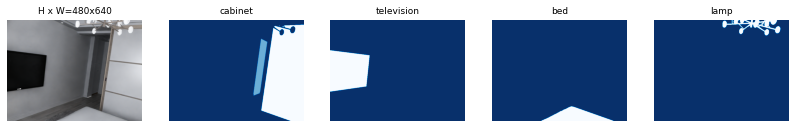

7334


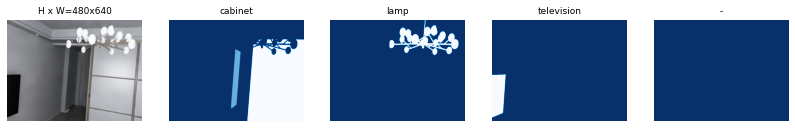

7332


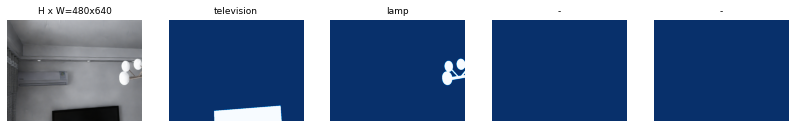

7338


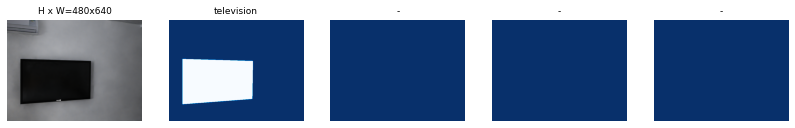

7325


In [8]:
image_ids = dataset_train.load_view(5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
class InferenceConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 2000
    VALIDATION_STEPS = 300
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.07
    vmax = 1.07
    nvox = 40
    nvox_z = 40
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 10
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    LEARNING_RATE = 0.001
    GRID_REAS = 'ident'
    BACKBONE = 'resnet50'
    TOP_DOWN_PYRAMID_SIZE = 64
    VANILLA = False

config_stage1 = InferenceConfig()
config_stage1.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                35
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE       

In [10]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess= tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

# Create model in training mode
model = modellib.MaskRCNN(mode="inference", config=config_stage1,
                          model_dir=MODEL_DIR)
print(model.keras_model.summary())

# model_path = model.find_last()
# print(model_path)
from keras.engine import saving
import h5py
# f = h5py.File(os.path.join(model_path), mode='r')
f = h5py.File(os.path.join(MODEL_DIR, 'interiornet20200617T2352', 'backbone_sep.h5'), mode='r')
#f = h5py.File(COCO_MODEL_PATH, mode='r')
for layer in model.keras_model.layers:
    if layer.name == 'backbone':
        layers = layer.layers
        print(layer.__class__.__name__)
        saving.load_weights_from_hdf5_group_by_name(f, layer.layers)
        break
# model_path = model.find_last()
# print(model_path)
model_path = os.path.join(MODEL_DIR, 'interiornet20200618T0921', 'mask_rcnn_interiornet_0007.h5')
model.load_weights(model_path, by_name=True, exclude=["backbone"])
# model.load_weights(model_path, by_name=True)

input_image_0_shape: [None, 640, 640, 3]
shape of input: [640, 640, 3]
input_image_shape: [None, 640, 640, 3]
fn image_shape: [None, 640, 640, 3]
Instructions for updating:
Colocations handled automatically by placer.
shape_out: [None, 160, 160, 64]
shape_out: [None, 80, 80, 64]
shape_out: [None, 40, 40, 64]
shape_out: [None, 20, 20, 64]
shape_out: [None, 10, 10, 64]
finished whole bb model
finished
P2_t: [None, 1, 160, 160, 64]
P2_shape: [None, 2, 160, 160, 64]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
Instructions for updating:
Use tf.cast instead.
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shape: [3, 40, 40, 40]
grid position shape: [1, 3]
grid shap

normal model
input_image
lambda_1
lambda_7
lambda_2
lambda_8
lambda_6
lambda_12
lambda_3
lambda_9
lambda_4
lambda_10
lambda_5
lambda_11
lambda_13
input_R
input_Kmat
lambda_17
lambda_14
lambda_15
lambda_16
unproj_P2
unproj_P6
unproj_P3
unproj_P4
unproj_P5
lambda_23
lambda_24
lambda_25
lambda_26
lambda_27
activation_44
activation_47
activation_50
activation_53
activation_56
grid_reas_P2ident_conv
grid_reas_P3ident_conv
grid_reas_P4ident_conv
grid_reas_P5ident_conv
grid_reas_P6ident_conv
grid_reas_P2_batch_norm
grid_reas_P3_batch_norm
grid_reas_P4_batch_norm
grid_reas_P5_batch_norm
grid_reas_P6_batch_norm
activation_45
activation_48
activation_51
activation_54
activation_57
activation_46
activation_49
activation_52
activation_55
activation_58
projs_PG2
projs_PG3
projs_PG4
projs_PG5
projs_PG6
lambda_28
lambda_29
lambda_30
lambda_31
lambda_32
grid_reas_depth_PG22DConv
grid_reas_depth_PG32DConv
grid_reas_depth_PG42DConv
grid_reas_depth_PG52DConv
grid_reas_depth_PG62DConv
grid_reas_depth_PG2b

[570 581]
(2, 480, 640, 3)
(1, 2, 3, 4)
(1, 3, 3)
(480, 640, 3)
new function


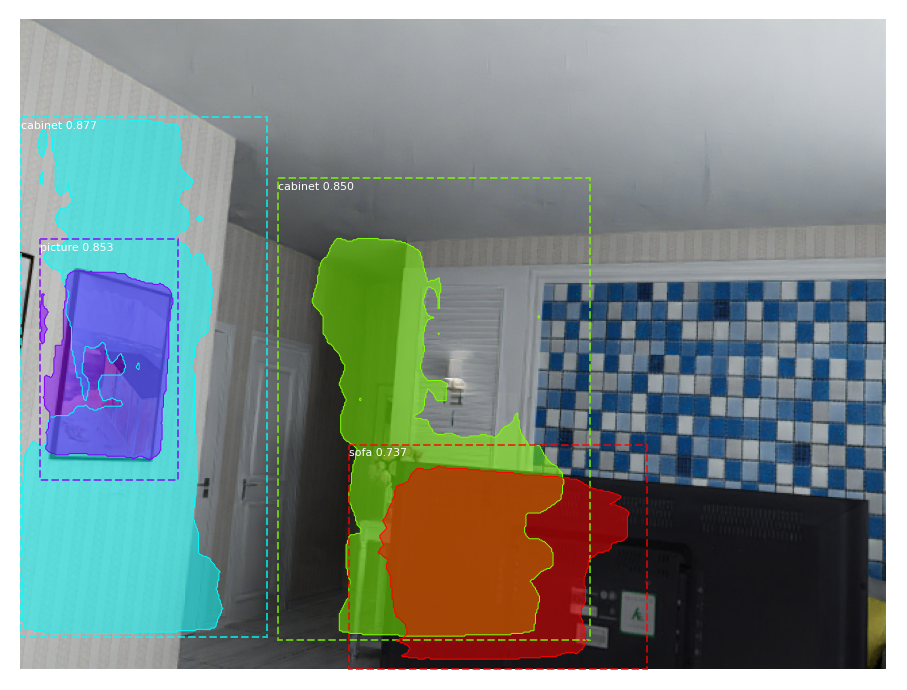

In [23]:
path = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD/test/3FO4MLNLVIOK_Bedroom/cam0/data/14.png'
SAVE_DIR = os.path.join(ROOT_DIR, 'data/Results/')

# image_ids = np.random.choice(dataset_train.image_ids, 20)
image_ids = np.asarray(dataset_val.load_view(2))
# image_ids = np.array([381, 397])
print(image_ids)
image_pairs = image_ids.reshape([-1,config_stage1.NUM_VIEWS])
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_val.K
    for image_id in image_pair:
        im.append(dataset_val.load_image(image_id))
        Rcam.append(dataset_val.load_R(image_id))
        
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)
    print(im[0].shape)
    results = model.detect([im], Rcam, Kmat)
    r = results[0]
    #for feature in r['mrcnn_features']
    #    key != 'q':
    #    plt.imshow()
    #    key = input()
        
    visualize.display_instances(im[0], r['rois'], r['masks'], r['class_ids'], 
                                selected_classes, r['scores'])
#     visualize.save_image(image_name = image_ids[0], image = im[0], boxes = r['rois'], masks = r['masks'], class_ids = r['class_ids'], class_names = selected_classes, scores = r['scores'], save_dir = SAVE_DIR)



In [12]:
print(r['mrcnn_features'][:,:,:].shape)
print(r['mrcnn_intermediate_features'].transpose([1,2,0])[:,:,:].shape)

# display_images(np.transpose(r['mrcnn_intermediate_features'].transpose([1,2,0])[:,:,-64:], [2,0,1]),cmap='gray')
display_images(np.transpose(r['mrcnn_features'][:,:,:64], [2,0,1]),cmap='gray')
# display_images(np.transpose(r['mrcnn_features'][:,:,:64], [2,0,1]),cmap='gray')
ax = get_ax()
plt.imshow(im[1])
print(r['mrcnn_features'][:,:,:64])
#print(r['mrcnn_features'][:,:,270])
#plt.imshow(r['mrcnn_features'][:,:,250])


(160, 160, 64)
(160, 160, 64)


[[[  1.0462785   19.636034    25.630266   ...  29.322641     1.1558347
    19.791512  ]
  [ -6.5823693    6.386076    27.081161   ...  24.870268    -6.0468135
    24.40714   ]
  [ -1.1602191    3.7348707   14.269525   ...  12.527306   -13.661649
    26.829077  ]
  ...
  [-10.058669     8.169576    21.637642   ...   9.260412     3.3301525
    27.140512  ]
  [  0.26618153   9.834257    26.896376   ...   4.7902827   -2.3469715
    23.130247  ]
  [-11.665834     1.9736996   11.567824   ...   5.8975577   -4.5980277
    10.299642  ]]

 [[ 19.898571     8.256293    26.890923   ...  19.01199      7.0980763
    27.248877  ]
  [  1.2482276  -24.292799    33.95823    ...  37.989162    -6.2746015
    33.82669   ]
  [ 11.66499    -19.421663    17.96534    ...  13.163944   -14.630365
    40.085564  ]
  ...
  [ -1.8519125   -8.229507    31.544283   ...  21.621        0.52580905
    45.558964  ]
  [  0.28808886  -4.402334    41.874317   ...  21.17479     -5.7703857
    41.900276  ]
  [-17.153053   -13

In [13]:
plt.imshow(im[2])


IndexError: index 2 is out of bounds for axis 0 with size 2